In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import SaveBestModel

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

Setting CUDA devices...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.device_count()

1

In [4]:
#torch.cuda.set_device(0)

In [5]:
DATASET_ROOT = '/media/data-nvme/dev/datasets/airbus/'
PATH = DATASET_ROOT
TRAIN = DATASET_ROOT + 'train_v2/'
TEST = DATASET_ROOT + 'test_v2/'
SEGMENTATION = DATASET_ROOT + 'train_ship_segmentations_v2.csv'
PRETRAINED = DATASET_ROOT + 'models/resnet34s256_kaggle-airbus-l0.053-a0.981.h5'
DETECTION_TEST_PRED = DATASET_ROOT + 'models/ship_detection.csv'

In [6]:
exclude_list = ['6384c3e78.jpg'] #corrupted image

In [7]:
nw = 12   #number of workers for data loader
arch = resnet34 #specify target architecture

In [8]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

In [9]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

In [10]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [11]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

In [12]:
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b,self.c = b,c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x  #add this line to fix the bug
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1/(c-1) if c<0 else c+1
        x = lighting(x, b, c)
        return x

In [13]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
                RandomDihedral(tfm_y=TfmType.CLASS),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
                aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
#     md.is_multi = False
    return md

In [14]:
cut,lr_cut = model_meta[arch]

In [15]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model, path): #load a model pretrained on ship/no-ship classification
    weights = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model

In [16]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [17]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [19]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [20]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [21]:
def save_when_acc(self, metrics):
#     loss, acc = metrics[0], metrics[1]
#     print(loss, acc)
    filename = "{}-{}-{}".format(self.name, self.epoch, random.randint(1,1000))
    print(filename)
    self.model.save(f'{filename}')
#     if self.best_acc == None or acc > self.best_acc:
#         self.best_acc = acc
#         self.best_loss = loss
#         self.model.save(f'{filename}')
#     elif acc == self.best_acc and  loss < self.best_loss:
#         self.best_loss = loss
#         self.model.save(f'{filename}')
SaveBestModel.save_when_acc = save_when_acc

In [22]:
m_base = load_pretrained(get_base(),PRETRAINED)
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [23]:
#models.model


In [24]:

# sz = 384 #image size
# bs = 28  #batch size

# md = get_data(sz,bs)

# learn = ConvLearner(md, models)
# #learn.model = torch.nn.DataParallel(learn.model)
# learn.opt_fn=optim.Adam
# learn.crit = MixedLoss(10.0, 2.0)
# learn.metrics=[accuracy_thresh(0.5),dice,IoU]
# wd=1e-7
# lr = 1e-2
# lrs = np.array([lr/100,lr/10,lr])
# learn.load('Unet34_s256_kaggle-airbus-l0.220-a0.999')
# md = get_data(sz,bs)
# learn.set_data(md)
# learn.unfreeze()
# learn.bn_freeze(True)

# learn.fit(lrs/5,2,wds=wd,cycle_len=2,use_clr=(10,8), best_save_name='Unet34_s' + str(sz) + "_kaggle-airbus")

# sz = 768 #image size
# bs = 6  #batch size
# md = get_data(sz,bs)
# learn.set_data(md)
# learn.unfreeze()
# learn.bn_freeze(True)
# learn.fit(lrs/10,2,wds=wd,cycle_len=1,use_clr=(10,8), best_save_name='Unet34_s' + str(sz) + "_kaggle-airbus")
# print("---------- End of ", i, "------------------------------")


In [25]:
#SaveBestModel.save_when_acc(SaveBestModel, metrics=learn.metrics)

In [26]:
#learn.metrics[1]

In [27]:
training_loop = [
    [1, 2, (20,8), 256, 64],
    [1, 2, (20,8), 256, 64],
    [1, 2, (20,8), 512, 32]
]
i = 0
for epochs, cycle_len, use_clr, sz, bs in training_loop:
    i+=1
    sz = 256 #image size
    bs = 64  #batch size
    md = get_data(sz,bs)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit = MixedLoss(10.0, 2.0)
    learn.metrics=[accuracy_thresh(0.5),dice,IoU]
    wd=1e-7
    lr = 1e-2
    learn.freeze_to(1)
    #learn.model = torch.nn.DataParallel(learn.model)
    print("SZ:", sz, "BS:", bs)
    learn.fit(lr,1,wds=wd,cycle_len=1,use_clr=(5,8), best_save_name='Unet34_s' + str(sz) + 'i' + str(i) + "_kaggle-airbus1")
    lrs = np.array([lr/100,lr/10,lr])
    learn.unfreeze() #unfreeze the encoder
    learn.bn_freeze(True)
    print("SZ:", sz, "BS:", bs)
    learn.fit(lrs,2,wds=wd,cycle_len=1,use_clr=(20,8), best_save_name='Unet34_s' + str(sz) + 'i' + str(i)  + "_kaggle-airbus2")
    print("SZ:", sz, "BS:", bs)
    learn.fit(lrs/3,2,wds=wd,cycle_len=2,use_clr=(20,8), best_save_name='Unet34_s' + str(sz) + 'i' + str(i)  + "_kaggle-airbus3")

    sz = 384 #image size
    bs = 28  #batch size
    md = get_data(sz,bs)
    learn.set_data(md)
    learn.unfreeze()
    learn.bn_freeze(True)
    print("SZ:", sz, "BS:", bs)
    learn.fit(lrs/5,2,wds=wd,cycle_len=2,use_clr=(10,8), best_save_name='Unet34_s' + str(sz)  + 'i' + str(i) + "_kaggle-airbus4")

    sz = 768 #image size
    bs = 6  #batch size
    md = get_data(sz,bs)
    learn.set_data(md)
    learn.unfreeze()
    learn.bn_freeze(True)
    print("SZ:", sz, "BS:", bs)
    learn.fit(lrs/10,2,wds=wd,cycle_len=1,use_clr=(10,8), best_save_name='Unet34_s' + str(sz)  + 'i' + str(i) + "_kaggle-airbus5")
    print("---------- End of ", i, "------------------------------")




Unet34_s256i1_kaggle-airbus1-1-138                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.303294   0.279718   0.998221   0.815545   0.689778  



[0.2797177008692306,
 0.9982207231292443,
 0.8155451332134592,
 0.6897779966458375]

Unet34_s256i1_kaggle-airbus2-1-429                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.267235   0.247474   0.998384   0.834922   0.717507  
Unet34_s256i1_kaggle-airbus2-3-635                           
    1      0.260556   0.245859   0.998399   0.836264   0.719571  



[0.24585858984487113,
 0.998399386013722,
 0.8362640496102367,
 0.7195707874685912]

Unet34_s256i1_kaggle-airbus3-1-525                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.242365   0.235443   0.998452   0.842381   0.728554  
Unet34_s256i1_kaggle-airbus3-3-484                           
    1      0.231534   0.22871    0.998494   0.846581   0.734801  
Unet34_s256i1_kaggle-airbus3-5-824                           
    2      0.244881   0.231935   0.998484   0.845139   0.732619  
Unet34_s256i1_kaggle-airbus3-7-685                           
    3      0.22333    0.21986    0.998537   0.851578   0.742318  



[0.2198604280869313,
 0.9985367511424913,
 0.8515780853475969,
 0.7423179190392415]

Unet34_s384i1_kaggle-airbus4-1-559                             
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.222315   0.207536   0.998626   0.859303   0.754703  
Unet34_s384i1_kaggle-airbus4-3-45                              
    1      0.207345   0.196645   0.998688   0.866231   0.765175  
Unet34_s384i1_kaggle-airbus4-5-209                             
    2      0.200717   0.195491   0.998703   0.867521   0.766948  
Unet34_s384i1_kaggle-airbus4-7-235                             
    3      0.192842   0.189537   0.998735   0.871316   0.772875  



[0.1895373402208145,
 0.9987346927692181,
 0.8713162204254137,
 0.7728752308764432]

Unet34_s768i1_kaggle-airbus5-1-747                               
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.286738   0.234132   0.998576   0.843538   0.736466  
Unet34_s768i1_kaggle-airbus5-3-641                               
    1      0.232376   0.219094   0.998678   0.852218   0.749047  



[0.2190943867684292,
 0.9986777166782598,
 0.8522183789618575,
 0.7490474789122777]

---------- End of  1 ------------------------------


Unet34_s256i2_kaggle-airbus1-1-273                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.23675    0.233878   0.998467   0.843372   0.73011   



[0.23387845243411673,
 0.9984669866050678,
 0.8433717940959825,
 0.7301101861951973]

Unet34_s256i2_kaggle-airbus2-1-633                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.22403    0.214515   0.998579   0.855034   0.747588  
Unet34_s256i2_kaggle-airbus2-3-294                           
    1      0.218171   0.209718   0.998609   0.858568   0.752895  



[0.20971810399053717,
 0.9986088064373531,
 0.8585682656760577,
 0.7528946001957172]

Unet34_s256i2_kaggle-airbus3-1-767                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.210683   0.20708    0.998625   0.859778   0.75474   
Unet34_s256i2_kaggle-airbus3-3-911                           
    1      0.203242   0.200934   0.998655   0.863514   0.760464  
Unet34_s256i2_kaggle-airbus3-5-519                           
    2      0.211819   0.20279    0.998641   0.86239    0.758752  
Unet34_s256i2_kaggle-airbus3-7-99                            
    3      0.20431    0.196423   0.998675   0.866526   0.765046  



[0.19642279549138603,
 0.9986748129074322,
 0.8665258166089296,
 0.7650458477781793]

Unet34_s384i2_kaggle-airbus4-1-968                             
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.19251    0.183408   0.99877    0.874715   0.77826   
Unet34_s384i2_kaggle-airbus4-3-30                              
    1      0.183023   0.17898    0.998801   0.877704   0.782907  
Unet34_s384i2_kaggle-airbus4-5-174                             
    2      0.185514   0.177816   0.998806   0.878751   0.784489  
Unet34_s384i2_kaggle-airbus4-7-655                             
    3      0.173748   0.173618   0.998833   0.881314   0.788569  



[0.17361793204343254,
 0.9988332236540296,
 0.8813137523347921,
 0.7885694894905232]

Unet34_s768i2_kaggle-airbus5-1-881                               
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.225348   0.219834   0.998688   0.852595   0.75039   
Unet34_s768i2_kaggle-airbus5-3-501                               
    1      0.204226   0.211755   0.998733   0.85753    0.757859  



[0.2117552371650879, 0.9987326699572437, 0.857530483931248, 0.7578594281911409]

---------- End of  2 ------------------------------


Unet34_s256i3_kaggle-airbus1-1-818                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.228381   0.217314   0.998565   0.854153   0.746252  



[0.2173143972861348,
 0.9985651881769713,
 0.8541532768119064,
 0.7462520968451297]

Unet34_s256i3_kaggle-airbus2-1-706                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.210458   0.202475   0.998639   0.862588   0.758996  
Unet34_s256i3_kaggle-airbus2-3-686                           
    1      0.202249   0.196662   0.998681   0.866384   0.764843  



[0.19666158065007047,
 0.9986811940198465,
 0.8663836756166822,
 0.7648427145979101]

Unet34_s256i3_kaggle-airbus3-1-793                           
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.196969   0.19328    0.998705   0.868748   0.768508  
Unet34_s256i3_kaggle-airbus3-3-226                           
    1      0.192704   0.18937    0.998725   0.871189   0.772277  
Unet34_s256i3_kaggle-airbus3-5-458                           
    2      0.202629   0.191812   0.998709   0.869849   0.770207  
Unet34_s256i3_kaggle-airbus3-7-64                            
    3      0.193558   0.187426   0.998734   0.872343   0.774106  



[0.18742559483884222,
 0.9987343809741261,
 0.8723429661801915,
 0.7741060966484647]

Unet34_s384i3_kaggle-airbus4-1-705                             
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.182029   0.174015   0.998831   0.881211   0.788458  
Unet34_s384i3_kaggle-airbus4-3-894                             
    1      0.17267    0.171453   0.998849   0.882929   0.791221  
Unet34_s384i3_kaggle-airbus4-5-851                             
    2      0.178515   0.170529   0.998856   0.883541   0.792179  
Unet34_s384i3_kaggle-airbus4-7-148                             
    3      0.172256   0.16689    0.998878   0.88579    0.79573   



[0.1668896054824928,
 0.9988779591985198,
 0.8857899380920115,
 0.7957301262125731]

Unet34_s768i3_kaggle-airbus5-1-976                               
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.214635   0.210722   0.998707   0.857685   0.756704  
Unet34_s768i3_kaggle-airbus5-3-481                               
    1      0.205862   0.202209   0.998773   0.862338   0.764298  



[0.20220859294375076,
 0.9987725689318616,
 0.8623378842573289,
 0.7642977872997687]

---------- End of  3 ------------------------------


In [28]:
#learn.load('Unet34_s256_kaggle-airbus-l0.222-a0.999')

In [29]:
# def Show_images(x,yp,yt):
#     columns = 3
#     rows = min(bs,8)
#     fig=plt.figure(figsize=(columns*4, rows*4))
#     for i in range(rows):
#         fig.add_subplot(rows, columns, 3*i+1)
#         plt.axis('off')
#         plt.imshow(x[i])
#         fig.add_subplot(rows, columns, 3*i+2)
#         plt.axis('off')
#         plt.imshow(yp[i])
#         fig.add_subplot(rows, columns, 3*i+3)
#         plt.axis('off')
#         plt.imshow(yt[i])
#     plt.show()

In [30]:
# learn.model.eval();
# x,y = next(iter(md.val_dl))
# yp = to_np(F.sigmoid(learn.model(V(x))).cpu())

Unet34(
  (rn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


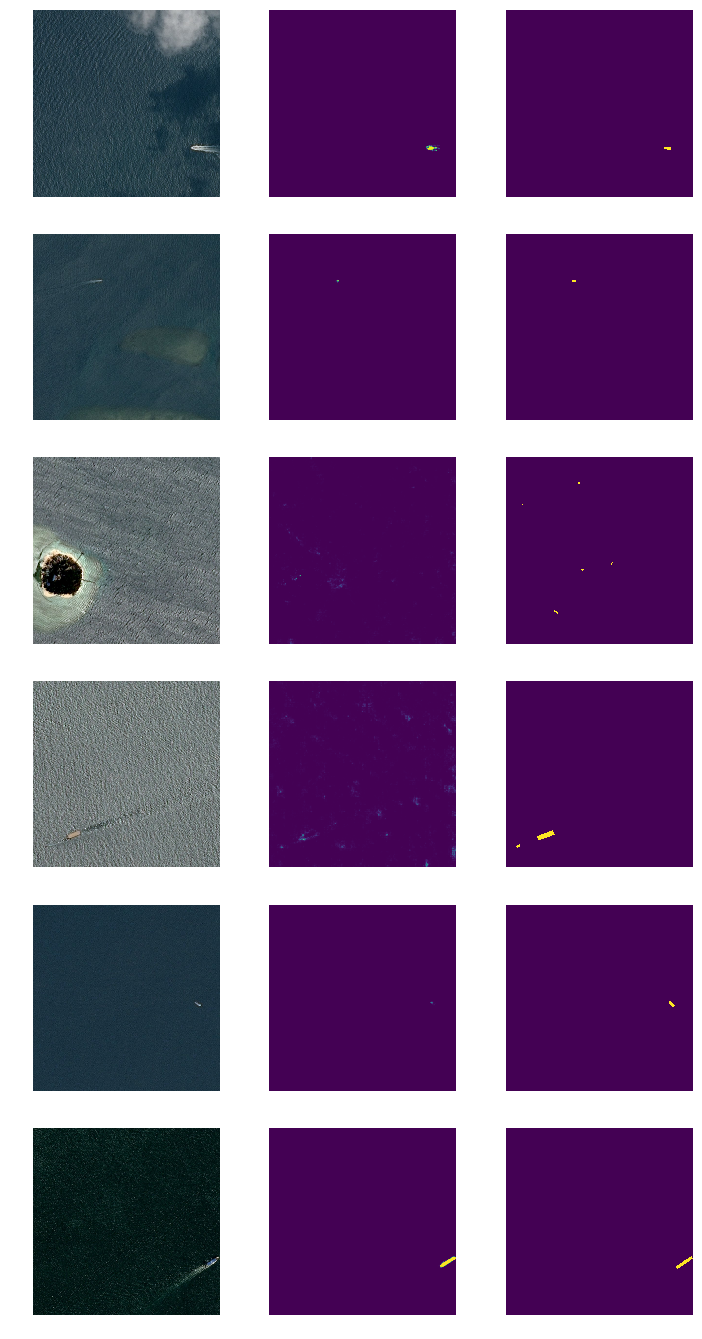

In [31]:
#Show_images(np.asarray(md.val_ds.denorm(x)), yp, y.cpu())